# TensorFlow, Keras with ResNet50: People Age-Image Regressor (Part 1)
In this project, a model is trained to predict the age of people in pictures. The pretrained model 'ResNet50' is used. This document is the first part of the whole training process.

The dataset can be found in:



Other useful datasets:

https://www.kaggle.com/datasets/karakaggle/kaggle-cat-vs-dog-dataset

## Iteration 1: Model creation and training (learning_rate=1e-3) without data augmentation (no fine-tuning yet)

In [1]:
# (height, width, channels)
input_shape = (224, 224, 3)
batch_size = 8
learning_rate = 1e-3
neurons = 64
path_dataset = '../dataset'
folder_models = '../models'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

2025-10-07 22:53:16.927520: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-07 22:53:22.771524: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-07 22:53:22.779769: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-07 22:53:32.302399: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Find how many images exist
imgs = os.listdir(path_dataset)
num_imgs = len(imgs)
print(f'Total images found: {num_imgs}')

Total images found: 24101


### No Data augmentation

In [4]:
def extract_age_from_filename(filename):
    """Extrae la edad desde el primer número del nombre del archivo."""
    return float(filename.split('_')[0])

def create_dataframe_from_directory(directory):
    """Crea un DataFrame con nombres de archivo y edades como etiquetas."""
    filenames = [f for f in os.listdir(directory) if f.endswith('.jpg')]
    ages = [extract_age_from_filename(f) for f in filenames]
    df = pd.DataFrame({'filename': filenames, 'age': ages})
    return df

In [5]:
def load_regression_data(path, input_shape=input_shape, batch_size=batch_size, seed=123, validation_split=0.2):
    """Crea generadores de imágenes para regresión lineal."""
    height, width = input_shape[:2]
    df = create_dataframe_from_directory(path)

    # Separar en entrenamiento y validación
    train_df = df.sample(frac=1 - validation_split, random_state=seed)
    val_df = df.drop(train_df.index)

    datagen = ImageDataGenerator(rescale=1.0/255, zoom_range=0,
        horizontal_flip=False, vertical_flip=False,
        height_shift_range=0, width_shift_range=0,
        brightness_range=(0.99, 1.0), rotation_range=0)

    train_data = datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=path,
        x_col='filename',
        y_col='age',
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='raw',  # For regression
        seed=seed
    )
    
    datagen_val = ImageDataGenerator(rescale=1.0/255)
    val_data = datagen_val.flow_from_dataframe(
        dataframe=val_df,
        directory=path,
        x_col='filename',
        y_col='age',
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='raw',
        seed=seed
    )

    return train_data, val_data

In [6]:
# Split training and validation datasets
train, val = load_regression_data(path_dataset)

print(f"Training images: {train.samples}")
print(f"Validation images: {val.samples}")

Found 19279 validated image filenames.
Found 4820 validated image filenames.
Training images: 19279
Validation images: 4820


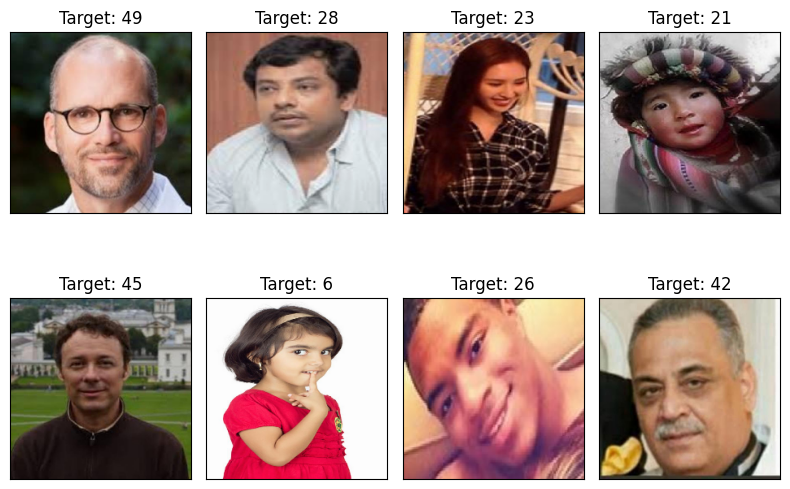

(8, 224, 224, 3)


In [7]:
# Obtain images and target
images, labels = next(train)

# Show 8 training images (batch_size=8)
figure, axes = plt.subplots(nrows=2,ncols=4, figsize=(8, 6))
for item in zip(axes.ravel(), images, labels):
    axes, image, target = item
    axes.imshow(image)
    axes.set_title(f'Target: {target:.0f}')
    axes.set_xticks([])
    axes.set_yticks([])
plt.tight_layout()
plt.show()

# Image dimensions
print(images.shape)

### Model training

In [8]:
def create_resnet_model(input_shape=input_shape, neurons=neurons,
                        learning_rate=learning_rate):
    """Function to create the model using the pretrained model
    'ResNet50' and adding some final layers. The backbone is 'ResNet50',
    but it is freezed (not trained) in this iteration."""
    
    backbone = ResNet50(weights='imagenet', input_shape=input_shape,
                        include_top=False)

    # Freeze ResNet50 without the top
    backbone.trainable = False
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(1, activation='relu'))  # For regression, Single output
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='mse', metrics=['mae'])
    return model

def train_model(model, train_data, val_data, epochs, version_model):
    """Function to train the model and save the best one
    according to the min MAE."""
    file_name = os.path.join(folder_models,f'regression_model_v{version_model}.h5')
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=0),
        ModelCheckpoint(file_name, monitor='val_mae', save_best_only=True, mode='min', verbose=1)
    ]

    history = model.fit(train_data, validation_data=val_data,
              epochs=epochs, callbacks=callbacks, verbose=2)

    return model, history

In [9]:
epochs = 20
version_model = 1
print(f"Parameters: batch_size = {batch_size}, learning_rate = {learning_rate}, neurons = {neurons}, epochs = {epochs}")

Parameters: batch_size = 8, learning_rate = 0.001, neurons = 64, epochs = 20


In [10]:
# Create and train the model v1
model = create_resnet_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 23718913 (90.48 MB)
Trainable params: 131201 (512.50 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [11]:
print(f"TensorFlow Version: {tf.__version__}")

# Ensure GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0],True)
    print("GPU is available and memory growth is enabled.")
else:
    print("GPU not available, training will be on CPU.")

TensorFlow Version: 2.13.1
GPU not available, training will be on CPU.


In [12]:
# Train the model
model, history_stage1 = train_model(model, train, val, epochs=epochs, version_model=version_model)

Epoch 1/20

Epoch 1: val_mae improved from inf to 15.96745, saving model to ../models/regression_model_v1.h5


/home/ant/TensorFlow-Keras-ResNet50-HuggingFace/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2410/2410 - 1655s - loss: 873.8516 - mae: 23.0980 - val_loss: 405.9620 - val_mae: 15.9674 - lr: 0.0010 - 1655s/epoch - 687ms/step
Epoch 2/20

Epoch 2: val_mae improved from 15.96745 to 15.24239, saving model to ../models/regression_model_v1.h5
2410/2410 - 1589s - loss: 396.6942 - mae: 15.2901 - val_loss: 394.9709 - val_mae: 15.2424 - lr: 0.0010 - 1589s/epoch - 659ms/step
Epoch 3/20

Epoch 3: val_mae improved from 15.24239 to 15.14082, saving model to ../models/regression_model_v1.h5
2410/2410 - 1569s - loss: 390.8774 - mae: 15.1749 - val_loss: 390.9801 - val_mae: 15.1408 - lr: 0.0010 - 1569s/epoch - 651ms/step
Epoch 4/20

Epoch 4: val_mae did not improve from 15.14082
2410/2410 - 1563s - loss: 387.1406 - mae: 15.0863 - val_loss: 387.8602 - val_mae: 15.2774 - lr: 0.0010 - 1563s/epoch - 649ms/step
Epoch 5/20

Epoch 5: val_mae improved from 15.14082 to 15.08374, saving model to ../models/regression_model_v1.h5
2410/2410 - 1534s - loss: 384.4408 - mae: 15.0436 - val_loss: 385.2982 - val_ma

**Result 1:** val_mae=14.5.

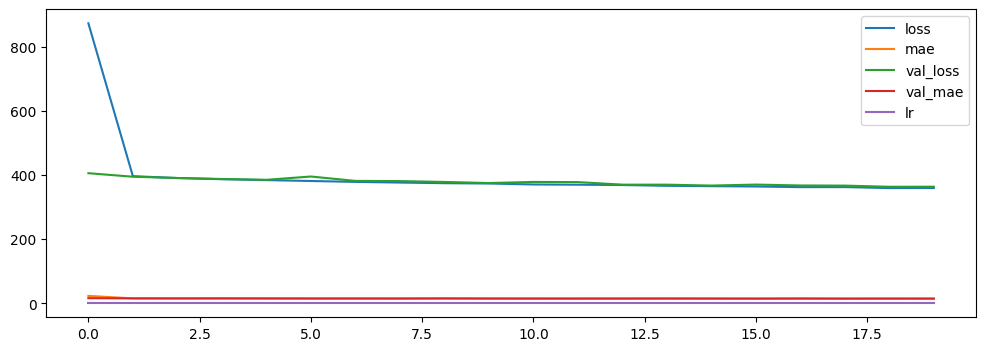

In [13]:
pd.DataFrame(history_stage1.history).plot(figsize=(12, 4))
plt.show()

In [ ]:
# Save model
# model.save(os.path.join(folder_models,f'binary_model_v{version_model}.keras'))

In the next iteration, the model will be retrained, data augmentation and fine-tuning will be performed.